In [295]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import pandas as pd
from skimage import data, io, filters
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [296]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

#Y' = 0.299 R + 0.587 G + 0.114 B 
def RGB_to_grey(image):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return 0.299* R + 0.587* G + 0.114* B 

# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename,n_features):
    img = load_image(filename)
    img_patches = np.asarray(img_crop(img, patch_size, patch_size))
    print(img_patches.shape)
    X =extract_new_features(img_patches,n_features)
    return X
    

In [297]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0



In [298]:
n_features=18;

In [299]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files = list(np.sort(files))
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


n = 100 # Only use 10 images for training
files

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


['satImage_001.png',
 'satImage_002.png',
 'satImage_003.png',
 'satImage_004.png',
 'satImage_005.png',
 'satImage_006.png',
 'satImage_007.png',
 'satImage_008.png',
 'satImage_009.png',
 'satImage_010.png',
 'satImage_011.png',
 'satImage_012.png',
 'satImage_013.png',
 'satImage_014.png',
 'satImage_015.png',
 'satImage_016.png',
 'satImage_017.png',
 'satImage_018.png',
 'satImage_019.png',
 'satImage_020.png',
 'satImage_021.png',
 'satImage_022.png',
 'satImage_023.png',
 'satImage_024.png',
 'satImage_025.png',
 'satImage_026.png',
 'satImage_027.png',
 'satImage_028.png',
 'satImage_029.png',
 'satImage_030.png',
 'satImage_031.png',
 'satImage_032.png',
 'satImage_033.png',
 'satImage_034.png',
 'satImage_035.png',
 'satImage_036.png',
 'satImage_037.png',
 'satImage_038.png',
 'satImage_039.png',
 'satImage_040.png',
 'satImage_041.png',
 'satImage_042.png',
 'satImage_043.png',
 'satImage_044.png',
 'satImage_045.png',
 'satImage_046.png',
 'satImage_047.png',
 'satImage_04

In [300]:
def create_train_table(n_column,n_features):
    return np.zeros([n_column,n_features]);

def add_feature(train_tx,new_column_feature):
        train_tx_new=np.ones([train_tx.shape[0],train_tx.shape[1]+1]);
      
        train_tx_new[:,0:train_tx.shape[1]]=train_tx;
        train_tx_new[:,train_tx.shape[1]]=new_column_feature;
        return train_tx_new;

def extract_mean_RGB(img):
    R = img[:,:,0];
    G = img[:,:,1];
    B = img[:,:,2];
    mean_R = np.mean(R);
    mean_G  = np.mean(G);
    mean_B=  np.mean(B);
    return [mean_R,mean_G,mean_B]


def extract_variance_RGB(img):
    R = img[:,:,0];
    G = img[:,:,1];
    B = img[:,:,2];
    var_R = np.var(R);
    var_G  = np.var(G);
    var_B=  np.var(B);
    return [var_R,var_G,var_B]

def get_spectrum(img_patches):
    dim=img_patches.shape;
    imgs_fourier=np.zeros([dim[0],dim[1],dim[2],dim[3],2])
    for i in range(len(img_patches)):
        img=img_patches[i];
        f = np.fft.fft2(img)
        imgs_fourier[i,:,:,:,0] = np.angle(f);
        imgs_fourier[i,:,:,:,1] = np.abs(f);
        
        
    return imgs_fourier;
        

def extract_mean_spectrum(spectrum):
    phase_1 = spectrum[:,:,0,0];
    phase_2= spectrum[:,:,1,0];
    phase_3= spectrum[:,:,2,0];
    abs_1 = spectrum[:,:,0,0];
    abs_2= spectrum[:,:,1,0];
    abs_3= spectrum[:,:,2,0];
    
    mean_phase_1=np.mean(phase_1);
    mean_phase_2=np.mean(phase_2);
    mean_phase_3=np.mean(phase_3);
    mean_abs_1=np.mean(abs_1);
    mean_abs_2=np.mean(abs_2);
    mean_abs_3=np.mean(abs_1);
    
   
    return  [mean_phase_1,mean_phase_2,mean_phase_3,mean_abs_1,mean_abs_2,mean_abs_3]


def extract_variance_spectrum(img):
    phase_1 = spectrum[:,:,0,0];
    phase_2= spectrum[:,:,1,0];
    phase_3= spectrum[:,:,2,0];
    abs_1 = spectrum[:,:,0,0];
    abs_2= spectrum[:,:,1,0];
    abs_3= spectrum[:,:,2,0];
    
    var_phase_1=np.var(phase_1);
    var_phase_2=np.var(phase_2);
    var_phase_3=np.var(phase_3);
    var_abs_1=np.var(abs_1);
    var_abs_2=np.var(abs_2);
    var_abs_3=np.var(abs_1);
    return  [var_phase_1,var_phase_2,var_phase_3,var_abs_1,var_abs_2,var_abs_3]



In [301]:
#extracting the mean and variance  of R G B ...
#starting to fill the train matrix


def extract_new_features(img_patches,n_features):


    train_tx=create_train_table(len(img_patches),n_features);
    for i in range(len(img_patches)):
        [mean_R,mean_G,mean_B]=extract_mean_RGB(img_patches[i]);
        train_tx[i,0]=mean_R;
        train_tx[i,1]=mean_G;
        train_tx[i,2]=mean_B;
        [var_R,var_G,var_B]=extract_variance_RGB(img_patches[i]);
        train_tx[i,3]=var_R;
        train_tx[i,4]=var_G;
        train_tx[i,5]=var_B;


    img_patches_fourier=get_spectrum(img_patches)
    for i in range(len(img_patches_fourier)):
        [mean_abs1,mean_abs2,mean_abs3,mean_phase1,mean_phase2,mean_phase3]=extract_mean_spectrum(img_patches_fourier[i]);
        train_tx[i,6]=mean_abs1;
        train_tx[i,7]=mean_abs2;
        train_tx[i,8]=mean_abs3;
        train_tx[i,9]=mean_phase1;
        train_tx[i,10]=mean_phase2;
        train_tx[i,11]=mean_phase3;

        [var_abs1,var_abs2,var_abs3,var_phase1,var_phase2,var_phase3]=extract_mean_spectrum(img_patches_fourier[i]);    
        train_tx[i,12]=mean_abs2;
        train_tx[i,13]=mean_abs2;
        train_tx[i,14]=mean_abs3;
        train_tx[i,15]=mean_phase1;
        train_tx[i,16]=mean_phase2;
        train_tx[i,17]=mean_phase3;
    
    
    return train_tx




In [302]:
# Extract patches from input images
patch_size =16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

X=extract_new_features(img_patches,n_features)

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
print(Y)

[0 0 0 ..., 0 0 1]


In [303]:
print(Y.shape)

(62500,)


In [304]:
def add_ones(tx):
    """
	Add column of ones to the dataset tx
    """
    return np.concatenate((tx, np.ones([tx.shape[0],1])), axis=1)



In [305]:
def build_poly(x, degree):
    """ Returns the polynomial basis functions for input data x, for j=2 up to j=degree."""
    return np.array([x**p for p in range(2,degree+1)]).T 

In [339]:
def add_powers(tx, degree):
    print(tx.shape)
    for col in range(0,tx.shape[1]): 
            tx = np.concatenate((tx, build_poly(tx[:,col], degree)), axis=1)
    return tx

In [340]:
X=add_powers(X, 4)
X=add_ones(X)
print(X.shape)

(62500, 73)
(62500, 293)


In [341]:
def build_k_indices(y, k_fold, seed):
    """Build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [342]:
def cross_validation_one_fold_logistic_regularized(y_cross_val_train, y_cross_val_test, tx_cross_val_train, tx_cross_val_test, \
                                 degrees, lambdas, max_iters):
    
    accuracies_train_by_deg = np.zeros([len(degrees),len(lambdas)])
    accuracies_test_by_deg = np.zeros([len(degrees),len(lambdas)])
    
    # For each degree, compute the least squares weights, the predictions and the accuracies
    previous_deg = 1
    for deg_id, deg in enumerate(degrees):
        print('++ Degree', deg, '++')
                
        # Add powers of the chosen columns
        len_data = tx_cross_val_train.shape[1]
        tx_cross_val_train = add_powers(tx_cross_val_train,deg_id )
        tx_cross_val_test = add_powers(tx_cross_val_test,deg_id )
        for lambda_id, single_lambda in enumerate(lambdas):
                
                print('>> Lambda', single_lambda, '<<')
            # Compute the best weights on the training set
                logreg = linear_model.LogisticRegression(C=1/single_lambda, class_weight="balanced",max_iter=max_iters)
                logreg.fit(X, Y)

                # Compute the predictions
                y_predicted_cross_val_train = logreg.predict(tx_cross_val_train)
                y_predicted_cross_val_test = logreg.predict(tx_cross_val_test)

                # Compute the predictions
                y_predicted_cross_val_train = predict_labels(weights, tx_cross_val_train)
                y_predicted_cross_val_test = predict_labels(weights, tx_cross_val_test)

                # Compute the accuracies for each degree
                accuracies_train_by_deg[deg_id,lambda_id] = \
                    np.sum(y_predicted_cross_val_train == y_cross_val_train)/len(y_cross_val_train)
                accuracies_test_by_deg[deg_id,lambda_id] = \
                    np.sum(y_predicted_cross_val_test == y_cross_val_test)/len(y_cross_val_test)


            
        
        # Update the previous degree to the actual degree
        previous_deg = deg
        
    return accuracies_train_by_deg, accuracies_test_by_deg






In [343]:
def cross_validation_logistic_regularized(Y,X, degrees, lambdas, k_fold, seed, max_iters):
    
    # Get the indices so that we get the k'th subgroup in test, others in train, for each k
    k_indices = build_k_indices(Y, k_fold, seed)
    
    # Initialize matrix of computed accuracies for each degree and each fold
    accuracies_train_by_fold = np.zeros([len(degrees), len(lambdas), k_fold])
    accuracies_test_by_fold = np.zeros([len(degrees), len(lambdas), k_fold])

    
    for k in range(k_fold):
        print('--- Fold', k, '---')
        # Create the testing set for this fold number
        k_index = k_indices[k] # Indices of the testing set for fold k
        Y_cross_val_test = Y[k_index]
        X_cross_val_test = X[k_index,:]
        
        # Create the training set for this fold number
        mask = np.ones(len(Y), dtype=bool) # set all elements to True
        mask[k_index] = False # set test elements to False
        Y_cross_val_train = Y[mask] # select only True elements (ie train elements)
        X_cross_val_train = X[mask,:]
        
        # Compute the accuracies for each degree
        accuracies_train_by_fold[:,:,k], accuracies_test_by_fold[:,:,k] = cross_validation_one_fold_logistic_regularized\
            (Y_cross_val_train, Y_cross_val_test, X_cross_val_train, X_cross_val_test, \
                                 degrees, lambdas,max_iters)
    # Compute the mean accuracies over the folds, for each degree
    mean_accuracies_train_by_deg = np.mean(accuracies_train_by_fold, axis=3)
    mean_accuracies_test_by_deg = np.mean(accuracies_test_by_fold, axis=3)
    
    # Get the index of the best accuracy in the testing set
    max_id_deg_test,max_id_lambda = \
        np.unravel_index(mean_accuracies_test_by_deg.argmax(), mean_accuracies_test_by_deg.shape)
    
    # Find the optimal degree and the corresponding accuracies in the training and testing sets
    best_deg = degrees[max_id_deg_test]
    best_lambda=lambdas[max_id_lambda]
    best_accuracy_test = mean_accuracies_test_by_deg[max_id_deg_test,max_id_lambda]
    corresponding_accuracy_train = mean_accuracies_train_by_deg[max_id_deg_test,max_id_lambda]
    
    print('Best accuracy test =', best_accuracy_test, 'with degree =', best_deg)
    print('Corresponding accuracy train =', corresponding_accuracy_train)
    
    return best_deg, best_lambda, best_accuracy_test, corresponding_accuracy_train                        



In [344]:
degrees = range(6,11)
lambdas = np.logspace(-8,-2,6)
k_fold=2
seed = 1
max_iters = 300
best_deg,best_lambda, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_logistic_regularized(Y, X, degrees, lambdas, k_fold, seed, max_iters)
    

--- Fold 0 ---
++ Degree 6 ++
(31250, 293)


ValueError: all the input arrays must have same number of dimensions

In [308]:

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced",max_iter=100000)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

(625, 16, 16, 3)
(625, 18)
(625,)


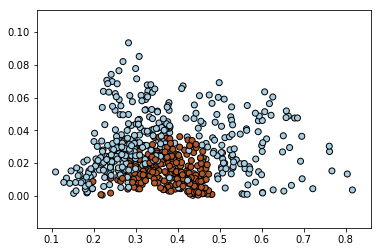

In [309]:


# we create an instance of the classifier and fit the data
img_idx = 15

Xi = extract_img_features(image_dir + files[img_idx],n_features)
print(Xi.shape)
Xi=add_powers(Xi, 4)
Xi=add_ones(Xi)

Zi = logreg.predict(Xi)
print(Zi.shape)
plt.scatter(Xi[:, 0], Xi[:, 3], c=Zi, edgecolors='k', cmap=plt.cm.Paired)


In [218]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    
    

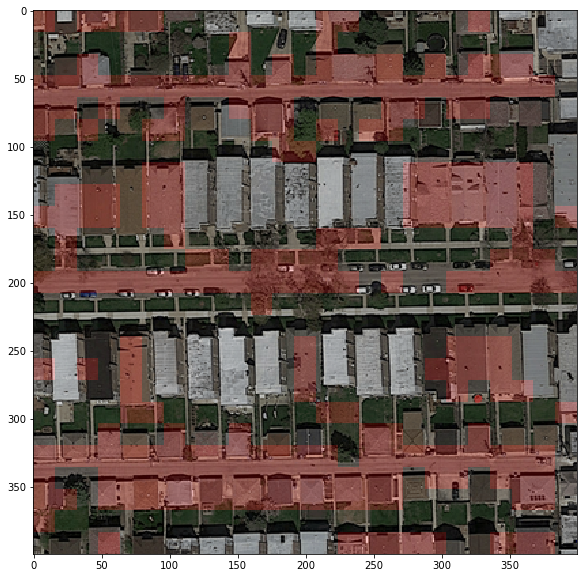

In [219]:
# Display prediction as an image
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]



predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)



# Prediction on test


In [272]:
import glob

root_dir = "test_set_images/";
files = os.listdir(root_dir)
n=len(files);

imgs=[];
for i in range(n-1):
    ind=i+1;
    image_dir="test_"+str(ind)+"/";
    path=root_dir+image_dir
    files = os.listdir(path)
    img = load_image(path + files[0])
    imgs.append(img)





In [273]:
img_idx = 15
print(len(imgs))



for i in range(len(imgs)):
    w = imgs[i].shape[0]
    h = imgs[i].shape[1]
    img_patches = np.asarray(img_crop(imgs[i], patch_size, patch_size))
    Xi = extract_new_features(img_patches,n_features)
    Xi=add_powers(Xi, 4)
    Xi=add_ones(Xi)
    Zi = logreg.predict(Xi)
    
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    ind=i+1;
    predicted_im =img_float_to_uint8(predicted_im )
    mpimg.imsave('prediction_corrected' + '%.3d' % ind + '.png',predicted_im)

50


In [274]:
from mask_to_submission import *

image_filenames=glob.glob('*.png')
print(image_filenames)
submission_filename='sample_submission.csv'
masks_to_submission(submission_filename, *image_filenames)

['prediction_corrected001.png', 'prediction_corrected002.png', 'prediction_corrected003.png', 'prediction_corrected004.png', 'prediction_corrected005.png', 'prediction_corrected006.png', 'prediction_corrected007.png', 'prediction_corrected008.png', 'prediction_corrected009.png', 'prediction_corrected010.png', 'prediction_corrected011.png', 'prediction_corrected012.png', 'prediction_corrected013.png', 'prediction_corrected014.png', 'prediction_corrected015.png', 'prediction_corrected016.png', 'prediction_corrected017.png', 'prediction_corrected018.png', 'prediction_corrected019.png', 'prediction_corrected020.png', 'prediction_corrected021.png', 'prediction_corrected022.png', 'prediction_corrected023.png', 'prediction_corrected024.png', 'prediction_corrected025.png', 'prediction_corrected026.png', 'prediction_corrected027.png', 'prediction_corrected028.png', 'prediction_corrected029.png', 'prediction_corrected030.png', 'prediction_corrected031.png', 'prediction_corrected032.png', 'predic

# Test di image Processing


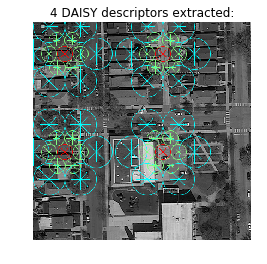

In [263]:
from skimage.feature import daisy
from skimage import data
import matplotlib.pyplot as plt


img = RGB_to_grey(imgs[1]);
descs, descs_img = daisy(img, step=180, radius=58, rings=2, histograms=6,
                         orientations=8, visualize=True)

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

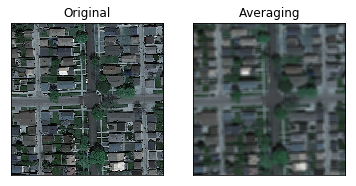

In [308]:
        # filters for averaging  
        import cv2
        import numpy as np
        from matplotlib import pyplot as plt

        img = cv2.imread('satImage_001.png')

        kernel = np.ones((9,9),np.float32)/81
        dst = cv2.filter2D(img,-1,kernel)

        plt.subplot(121),plt.imshow(img),plt.title('Original')
        plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
        plt.xticks([]), plt.yticks([])
        plt.show()

In [310]:
# template 
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_rgb = cv2.imread(image_dir+'satImage_001.png')


kernel = np.ones((9,9),np.float32)/81
img_rgb = cv2.filter2D(img_rgb,-1,kernel)


img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)


template = cv2.imread('albero2.png',0);


template = cv2.filter2D(template,-1,kernel)

w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.5
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)

True

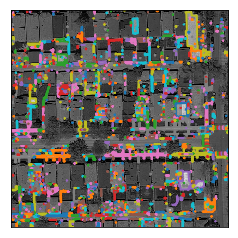

In [300]:
# contour
# try contour with skimage
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

image=RGB_to_grey(imgs[12]);
# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
contours = measure.find_contours(image, 0.5)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

(16, 16, 3)


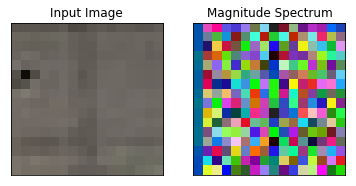

In [38]:
# spectrum __ seem to be not so informative

import cv2
import numpy as np
from matplotlib import pyplot as plt

img=img_patches[3456];
f = np.fft.fft2(img)

fshift = f
print(fshift.shape)
magnitude_spectrum = np.angle(fshift)

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

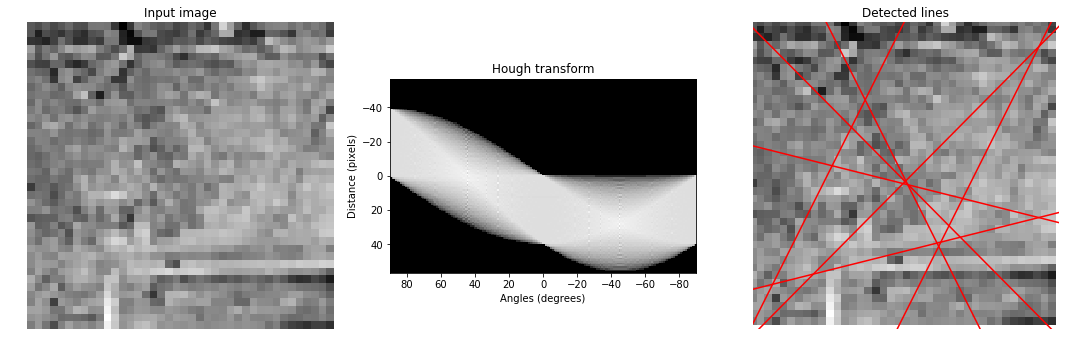

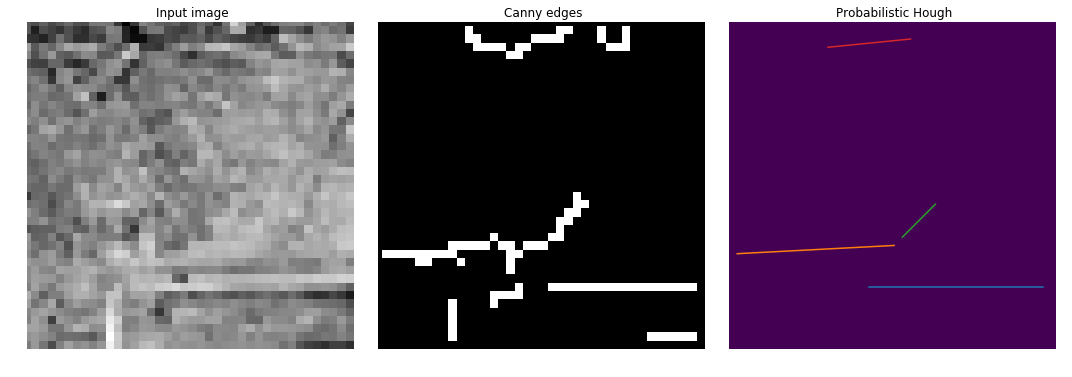

In [291]:
# try hough with skimage
import numpy as np

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

image_num = 532



# Constructing test image
image = np.zeros((100, 100))
idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255
image = RGB_to_grey(img_patches[image_num]) 

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

# Line finding using the Probabilistic Hough Transform
#image = data.camera()
image = RGB_to_grey(img_patches[image_num]) 
edges = canny(image, 1, 2, 1000)
edges = canny(image, sigma=1.5, low_threshold=0.1, high_threshold=0.2, mask=None, use_quantiles=False)
#edges = feature.canny(image,sigma=1.5)

lines = probabilistic_hough_line(edges, threshold=10, line_length=4,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

edges 
ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
    a.set_adjustable('box-forced')

plt.tight_layout()
plt.show()